In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 7.6MB/s 


In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from scipy.spatial.distance import cosine

import cv2
import mtcnn

from tensorflow.keras.models import load_model
from utils import *

In [ ]:
path0 = "./"

# Готовая модель доступна по ссылке 
# https://drive.google.com/drive/folders/12aMYASGCKvDdkygSv1yQq8ns03AStDO_
# Необходимо скачать модель расположить в текущей директории
encoder_model = path0 + 'facenet_keras.h5'

train_dir = path0 + 'train/'
encodings_path = path0 + 'encodings.pkl'
test_img_path = path0 + 'test/'

# Коэффициент, по которому измеряется схожесть лиц на фото
recognition_t = 0.4

required_size = (160, 160)
encoding_dict = dict()

# Функции

In [ ]:
def get_rect(img, bbox=True):
    '''
    Функция получает на вход фотографию, детектирует на них лица, и определяет,
    принадлежат ли они Джиму.
    Затем возвращает изображение с обведенным лицом и булевую переменную:
    True - Джим
    False - кто-либо еще
    '''
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detector.detect_faces(img_rgb)
    state = False
    for res in results:
        face, pt_1, pt_2 = get_face(img_rgb, res['box'])
        encode = get_encode(face_encoder, face, required_size)
        encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]
        
        name = 'unknown'
        distance = float("inf")
        
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = 'Jim'
                distance = dist
        if name == 'unknown':
            if bbox:
                cv2.rectangle(img, pt_1, pt_2, (0,0, 255),1)
                cv2.putText(img,name, pt_1,cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 1)
            else:
                pass
        else:
            if bbox:
                cv2.rectangle(img, pt_1, pt_2, (0, 255, 0),1)
                cv2.putText(img,name + f"__{distance:.2f}", pt_1 ,cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 1)
            state = True
    return img, state

In [2]:
def make_video(path, images):
    '''
    Функция записывает видео из полученных массивов
    '''
    video_writer = cv2.VideoWriter(path,
                                cv2.VideoWriter_fourcc(*'MPEG'), 
                                25.0, 
                                (frame_w, frame_h))

    # собираем все кадры в видео
    for i in range(len(images)):
        video_writer.write(images[i])

    # Ставим "точку", завершаем
    video_reader.release()
    video_writer.release()

# Нейронные сети

In [ ]:
# MTCNN - предобученный нейронный детектор лиц
face_detector = mtcnn.MTCNN()

In [ ]:
# В качестве энкодера используется предобученная нейросеть Keras-Facent 
# из репозитория nyoki-mtl/keras-facenet
face_encoder = load_model(encoder_model)

## Извлечение карт фичей

In [ ]:
# Получаем фичи лица Джима из 30 разных фильмов и передач
# Для этого используются две модели
# MTCNN - детектирует лица и вытаскивает их с фотографии
# Facenet - получает эти лица и раскладывает их на фичи.
# Фичи складываются и нормализуются для получения некоего "среднего" значения, 
# соответствующего всем лицам, которые относятся к передаче
# Затем все наборы фичей сохраняются в словаре

for person_name in os.listdir(train_dir):
    print(person_name)
    person_dir = os.path.join(train_dir, person_name)
    encodes = []
    for img_name in os.listdir(person_dir):
        img_path = os.path.join(person_dir, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_detector.detect_faces(img_rgb)
        if results:
            res = max(results, key=lambda b: b['box'][2] * b['box'][3])
            face, _, _ = get_face(img_rgb, res['box'])
            
            face = normalize(face)
            face = cv2.resize(face, required_size)
            encode = face_encoder.predict(np.expand_dims(face, axis=0))[0]
            encodes.append(encode)
            
    if encodes:
        encode = np.sum(encodes, axis=0)
        encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]
        encoding_dict[person_name] = encode

jim9
jim8
jim7
jim6
jim31
jim29
jim30
jim5
jim4
jim3
jim27
jim28
jim26
jim25
jim24
jim20
jim15
jim18
jim22
jim23
jim19
jim21
jim17
jim14
jim13
jim12
jim11
jim10
jim1
jim0


## Запись полученных карт фичей в .pickle

In [ ]:
save_pickle(encodings_path, encoding_dict)

# Проверка на тестовом изображении

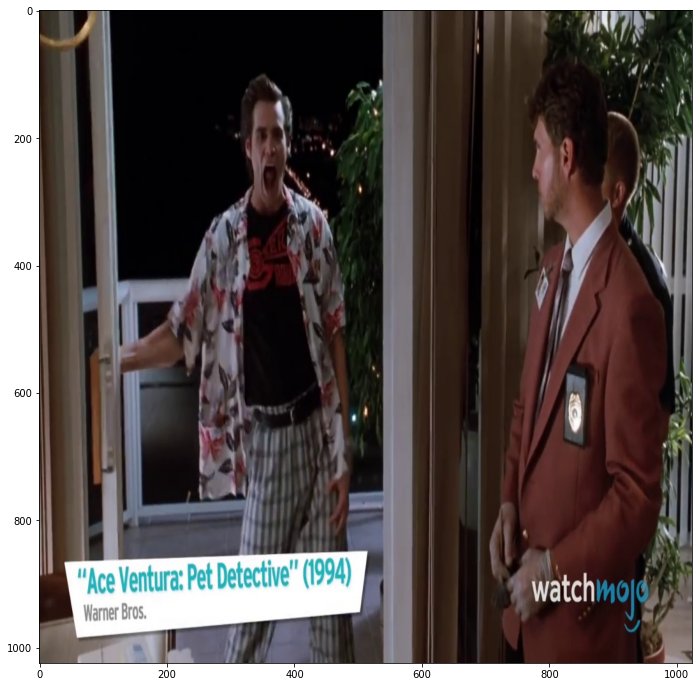

In [ ]:
plt.figure(figsize=(12,12))
img = cv2.imread(test_img_path + os.listdir(test_img_path)[0])
plt_show(img)

True


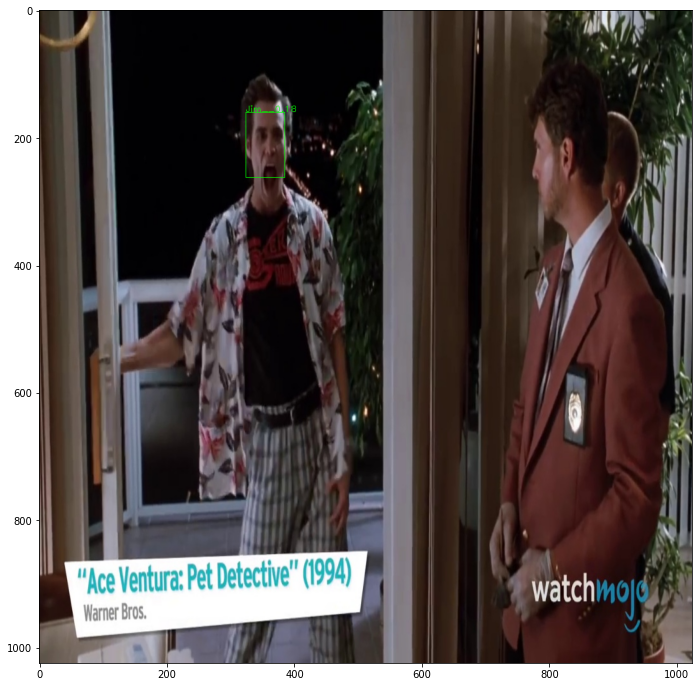

In [ ]:
plt.figure(figsize=(12,12))
img_, st = get_rect(img)
print(st)
plt_show(img_)